# Bibliography

Author : Dr. Sreenivas <br>

Youtube : [https://youtu.be/6S2v7G-OupA?si=-25V7djYiafSRdTP] <br>
Github : [https://github.com/bnsreenu/python_for_microscopists/blob/master/180_LSTM_encoder_decoder_anomaly_GE.py] <br>
Lecture Number : 180

# Libraries Required

In [1]:
from keras.models import Model
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import LSTM, Input, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Data

In [4]:
dataframe = pd.read_csv('data/lstmEnDeAnomaly2025-03.csv')
df = dataframe[['open_time','close']]
df['open_time'] = pd.to_datetime(df['open_time'], unit="ms", utc=True)

/tmp/ipykernel_206340/2729042393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open_time'] = pd.to_datetime(df['open_time'], unit="ms", utc=True)


/tmp/ipykernel_206340/101019335.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right') # ha for horizontal alignment


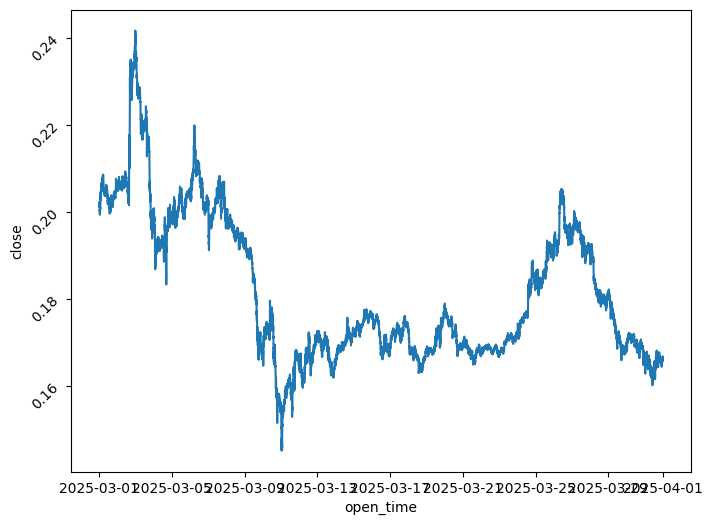

In [6]:
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x=df['open_time'], y=df['close'])

ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right') # ha for horizontal alignment
plt.show()